In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pylab as plt
%matplotlib inline

retail = pd.read_csv('/Users/feilynch/Desktop/COMP257/Portfolio3/files/online-retail.csv')
#retail.head()
#retail.shape
#retail.tail()

In [3]:
# explor data
retail.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [4]:
# drop no value rows
retail.dropna(subset = ['CustomerID', 'Description'], how = 'any', inplace = True)
retail.shape

(406829, 8)

In [5]:
# converted time series
retail['InvoiceDate'] = pd.to_datetime(retail.InvoiceDate)
#retail.head()
#retail.tail()

In [6]:
#retail['InvoiceDate'].min()
retail['InvoiceDate'].max()

Timestamp('2011-12-10 17:19:00')

In [7]:
ts = pd.to_datetime('2010-12-09')
sample = retail.loc[(retail.InvoiceDate >= ts) & (retail.Country == 'United Kingdom'), :]
#print(sample)

## now the sample dataframe only contains one year's invoice data dating from (2010-12-09 to 2011-12-10), There’s some research indicating that customer clusters vary geographically, so here I’ll restrict the data to one geographic unit, and one country the 'United Kingdom'.
sample.shape sample.head()
sample['Country'].nunique()
sample.describe() sample.info()

<function matplotlib.pyplot.plot>

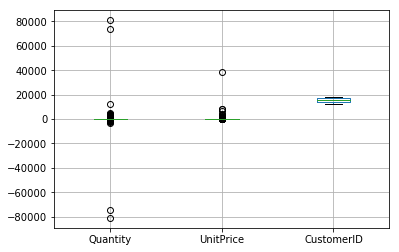

In [8]:
# first outliers detection, boxplot 
sample.boxplot(return_type = 'dict')
plt.plot

In [9]:
#dected the sample_outliers and removed
sample_outliers = sample[(sample.Quantity > 10000) | (sample.Quantity < -20000) | (sample.UnitPrice > 5000)]
print(sample_outliers)

       InvoiceNo StockCode                     Description  Quantity  \
61619     541431     23166  MEDIUM CERAMIC TOP STORAGE JAR     74215   
61624    C541433     23166  MEDIUM CERAMIC TOP STORAGE JAR    -74215   
173277   C551685      POST                         POSTAGE        -1   
173382    551697      POST                         POSTAGE         1   
173391   C551699         M                          Manual        -1   
222681   C556445         M                          Manual        -1   
502122    578841     84826  ASSTD DESIGN 3D PAPER STICKERS     12540   
540421    581483     23843     PAPER CRAFT , LITTLE BIRDIE     80995   
540422   C581484     23843     PAPER CRAFT , LITTLE BIRDIE    -80995   

               InvoiceDate  UnitPrice  CustomerID         Country  
61619  2011-01-18 10:01:00       1.04     12346.0  United Kingdom  
61624  2011-01-18 10:17:00       1.04     12346.0  United Kingdom  
173277 2011-03-05 12:51:00    8142.75     16029.0  United Kingdom  
173382 

In [10]:
# removed outliers
sample.drop([61619,61624,173277,173382,173391,222681,502122,540421,540422], axis=0, inplace = True)

/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


<function matplotlib.pyplot.plot>

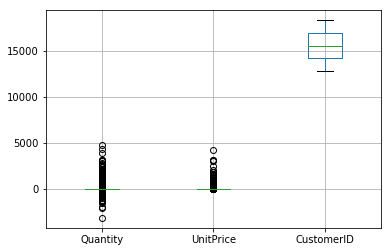

In [11]:
sample.boxplot(return_type = 'dict')
plt.plot

In [12]:
# add a column 'value' for the value of each transaction
sample = sample.assign(value=sample.Quantity * sample.UnitPrice)
sample.shape

(346911, 9)

In [13]:
# split into returns and sales, returns have a quantity less than zero
returns = sample.loc[sample.Quantity<=0]
sales = sample.loc[sample.Quantity>0]
print("Sales", sales.shape)
print("Returns", returns.shape)

Sales (339722, 9)
Returns (7189, 9)


In [18]:
## Adding Columns
sales_grouped = sales[['CustomerID', 'Quantity', 'UnitPrice', 'value']].groupby('CustomerID').aggregate(np.mean)

In [19]:
counts = sales.groupby('CustomerID').size().to_frame(name='count')
sales_grouped = sales_grouped.join(counts)

sales_grouped.describe()


,Quantity,UnitPrice,value,count
count,3848.000000,3848.000000,3848.000000,3848.000000
mean,21.567719,4.461601,37.606485,88.285343
std,108.611798,36.339719,252.195649,212.175321
min,1.000000,0.122500,1.450000,1.000000
25%,5.578818,2.141054,11.215179,16.000000
50%,9.827700,2.839631,17.291113,40.000000
75%,14.666667,3.733556,24.363820,97.250000
max,4300.000000,2033.100000,13305.500000,7661.000000


## This next step computes the time from each invoice date to the most recent invoice date and converts it to days. The following step then aggregates this per customer using max amount of days to get the most recent invoice per customer. This is then added to the sales_grouped dataframe. "

In [23]:
# add recency of purchases
recency = pd.to_datetime(sales.InvoiceDate)-pd.to_datetime("2011-12-10")
# get just the number of days so that we can use this value in clustering
recency = recency.apply(lambda x: x.days)

In [24]:
# turn recency into a dataframe with the customerID column from sales
recency_df = sales[['CustomerID']].assign(recency=recency)
# aggregate recency using max to get the most recent sale per customer
grp = recency_df[['CustomerID', 'recency']].groupby('CustomerID').aggregate(np.max)

In [27]:
# customers is our final dataframe of customer data
customers = sales_grouped.join(grp)
#customers.head()
customers.shape
#customers.head()

(3848, 5)

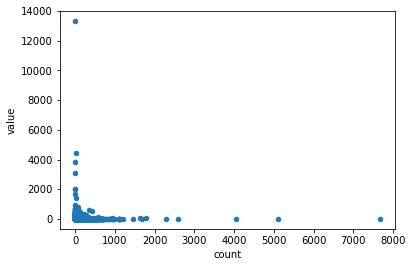

In [28]:
# step 1: Select parameters for clustering, By RFM therom, choosed: value ,count ,recency 3 features as parameters,group by customers ID
features_list = ['value','count','recency']
customers_data = customers.dropna(axis=0)[features_list]
CustomerID_groups = customers_data.groupby('CustomerID').mean().reset_index().dropna(axis=0)

#CustomerID_groups.shape
#CustomerID_groups.head()
#CustomerID_groups.describe()

# scatter plot the original data set
CustomerID_groups.plot('count', 'value', kind='scatter')

## This first graph uses the variables’ original metrics and is almost completely uninterpretable. There’s a clump of data points in the lower left-hand corner of the plot, and then a few outliers. This is why we log-transformed the input variables.

/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


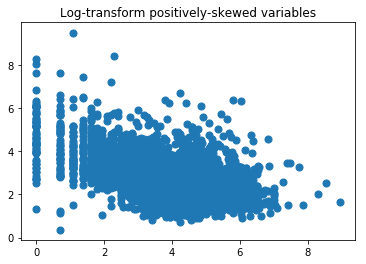

In [34]:
# Log-transform positively-skewed variables
CustomerID_groups['value_log'] = np.log(CustomerID_groups['value'])
CustomerID_groups['count_log'] = np.log(CustomerID_groups['count'])
CustomerID_groups['recency_log'] = np.log(CustomerID_groups['recency'])

#CustomerID_groups.shape
#CustomerID_groups.head()
#CustomerID_groups.describe()
plt.title('Log-transform positively-skewed variables')
plt.scatter(CustomerID_groups['count_log'],CustomerID_groups['value_log'], s=50)
plt.show()
#CustomerID_groups.plot('count_log', 'value_log', kind='scatter')

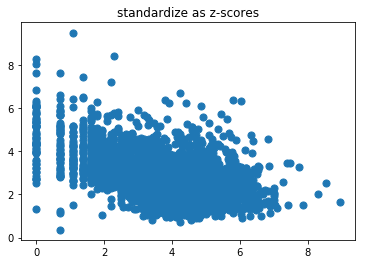

In [35]:
#standardize variables as z-scores.
from scipy import stats
CustomerID_groups['value_log_z']= np.array(CustomerID_groups['value_log'])
stats.zscore(CustomerID_groups['value_log_z'])

CustomerID_groups['count_log_z']= np.array(CustomerID_groups['count_log'])
stats.zscore(CustomerID_groups['count_log_z'])

#CustomerID_groups.head()
#CustomerID_groups.describe()
#CustomerID_groups.shape

#standardize as z-scores.
plt.title('standardize as z-scores')
plt.scatter(CustomerID_groups['count_log_z'],CustomerID_groups['value_log_z'], s=50)
plt.show()
#CustomerID_groups.plot('count_log_z', 'value_log_z', kind='scatter')

## We can see that the data points are fairly continuously-distributed. 75% of the data can be counted between(2-6),and values between(2-5), There really aren’t clear clusters. This means that any cluster groupings we create won’t exactly reflect the truth.

## This third scatterplot is basically identical to the second – it illustrates that even though we’ve changed the scaling for the analysis, the shape of the distributions and the relationships among the variables remain the same. Therefore we chose Log-transformed data sets for our K-Means analysis.

## And then we choose the 'elbow method' to determine the optimal K-values.

/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


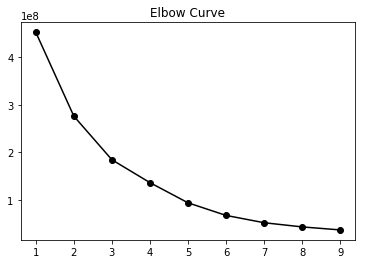

In [36]:
# stept 2 select K-Means clustering algorithm for our analysis
# using 'Elbow Method' to determine best number K for clustering

def elbow_plot(data, maxK=10, seed_centroids=None):
    """
        parameters:
        - data: pandas DataFrame (data to be fitted)
        - maxK (default = 10): integer (maximum number of clusters with which to run k-means)
        - seed_centroids (default = None ): float (initial value of centroids for k-means)
    """
    sse = {}
    for k in range(1, maxK):
        if seed_centroids is not None:
            seeds = seed_centroids.head(k)
            kmeans = KMeans(n_clusters=k, max_iter=500, n_init=100, random_state=0, init=np.reshape(seeds, (k,1))).fit(CustomerID_groups[features_list])
            data["clusters"] = kmeans.labels_
        else:
            kmeans = KMeans(n_clusters=k, max_iter=300, n_init=100, random_state=0).fit(CustomerID_groups[features_list])
            data["clusters"] = kmeans.labels_
        # Inertia: Sum of distances of samples to their closest cluster center
        sse[k] = kmeans.inertia_
   
   
    plt.figure()
    plt.title('Elbow Curve')
    plt.plot(list(sse.keys()), list(sse.values()),'ko-')
    plt.show()
    return

elbow_plot(CustomerID_groups[features_list])

## Following the clustering analysis for K = 9, 7 and 5 

In [37]:
# First we set K=9

km = KMeans(n_clusters=9)
CustomerID_groups['cluster'] = km.fit_predict(CustomerID_groups[features_list])
CustomerID_groups['cluster'].describe()
#CustomerID_groups.head()

CustomerID_groups.merge(CustomerID_groups[['CustomerID','cluster']]).groupby('cluster').mean()

,CustomerID,value,count,recency,value_log,count_log,recency_log,value_log_z,count_log_z
cluster,,,,,,,,,
0,15586.267925,17.441902,221.175472,-32.441509,2.550157,5.350006,-inf,2.550157,5.350006
1,15098.000000,13305.500000,3.000000,-65.000000,9.495933,1.098612,NaN,9.495933,1.098612
2,14895.000000,8.459168,5608.000000,-5.666667,2.065466,8.596671,-inf,2.065466,8.596671
3,16002.400000,3094.278000,3.000000,-152.800000,7.986006,0.599146,NaN,7.986006,0.599146
4,15529.403770,23.645391,29.052579,-234.349206,2.807964,2.885424,NaN,2.807964,2.885424
5,14252.142857,16.410216,1800.142857,-14.142857,2.441532,7.466500,-inf,2.441532,7.466500
6,15653.868687,14.105900,602.878788,-23.050505,2.261866,6.358900,-inf,2.261866,6.358900
7,15548.936449,26.097522,47.834579,-51.045794,2.924701,3.499388,-inf,2.924701,3.499388
8,15987.309091,463.066736,31.272727,-112.709091,6.038054,1.701536,NaN,6.038054,1.701536


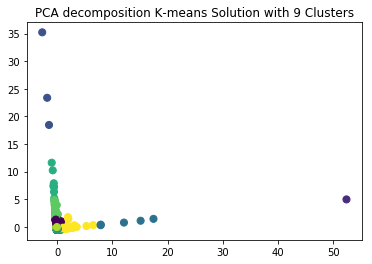

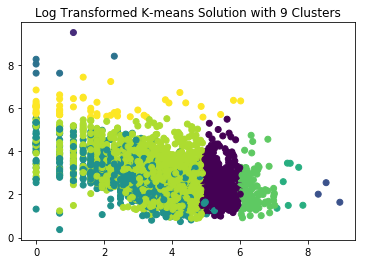

In [39]:
# principal Component Analysis: we choose Log Transformed and PCA decomposition to plot the clusting graph
from sklearn import decomposition
pca = decomposition.PCA(n_components=2, whiten=True)
pca.fit(CustomerID_groups[features_list])
CustomerID_groups['x'] = pca.fit_transform(CustomerID_groups[features_list])[:,0]
CustomerID_groups['y'] = pca.fit_transform(CustomerID_groups[features_list])[:,1]
plt.title('PCA decomposition K-means Solution with 9 Clusters')
plt.scatter(CustomerID_groups['x'],CustomerID_groups['y'], c=CustomerID_groups['cluster'], s=50 )
plt.show()

plt.title('Log Transformed K-means Solution with 9 Clusters')
plt.scatter(CustomerID_groups['count_log'],CustomerID_groups['value_log'], c=CustomerID_groups['cluster'] )
plt.show()

# graphs become very hard to interpret visually, and the cluster centers overlap each other starting to make distinctions that may not be that helpful .

In [40]:
# second set K=7

km = KMeans(n_clusters=7)
CustomerID_groups['cluster'] = km.fit_predict(CustomerID_groups[features_list])
CustomerID_groups['cluster'].describe()
#CustomerID_groups.head()

CustomerID_groups.merge(CustomerID_groups[['CustomerID','cluster']]).groupby('cluster').mean()

,CustomerID,value,count,recency,value_log,count_log,recency_log,value_log_z,count_log_z,x,y
cluster,,,,,,,,,,,
0,15546.979891,30.240468,58.898618,-48.511102,2.931743,3.645817,-inf,2.931743,3.645817,-0.020842,-0.113942
1,15098.000000,13305.500000,3.000000,-65.000000,9.495933,1.098612,NaN,9.495933,1.098612,52.387118,4.970224
2,14895.000000,8.459168,5608.000000,-5.666667,2.065466,8.596671,-inf,2.065466,8.596671,-1.985565,25.690396
3,15542.789174,32.432649,28.832858,-231.871795,2.875695,2.840662,NaN,2.875695,2.840662,0.004505,-0.350242
4,15182.043478,14.227207,1227.478261,-21.608696,2.186898,7.057218,-inf,2.186898,7.057218,-0.480319,5.325063
5,16090.666667,2859.765000,3.166667,-130.333333,7.893476,0.730338,NaN,7.893476,0.730338,11.167141,0.724444
6,15666.581333,20.153290,329.845333,-28.704000,2.480190,5.734932,-inf,2.480190,5.734932,-0.153014,1.151786


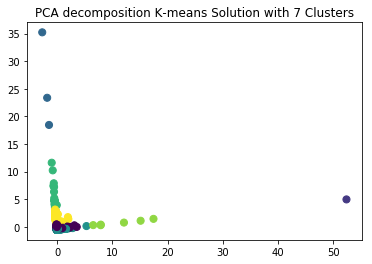

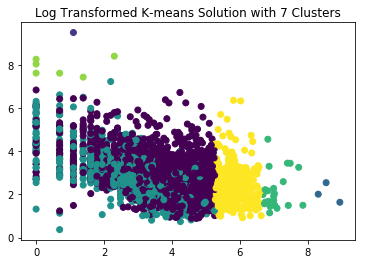

In [41]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=2, whiten=True)
pca.fit(CustomerID_groups[features_list])
CustomerID_groups['x'] = pca.fit_transform(CustomerID_groups[features_list])[:,0]
CustomerID_groups['y'] = pca.fit_transform(CustomerID_groups[features_list])[:,1]
plt.title('PCA decomposition K-means Solution with 7 Clusters')
plt.scatter(CustomerID_groups['x'],CustomerID_groups['y'], c=CustomerID_groups['cluster'], s=50 )
plt.show()

plt.title('Log Transformed K-means Solution with 7 Clusters')
plt.scatter(CustomerID_groups['count_log'],CustomerID_groups['value_log'], c=CustomerID_groups['cluster'] )
plt.show()




# the graph is a bit clearer than cluster 9, but still has a lot of overlapping present, but clearly we can see yellow dot group customers have some value, they also have high frequency with a reasonable purchase value.

In [46]:
# Third set K=5

km = KMeans(n_clusters=5)
CustomerID_groups['cluster'] = km.fit_predict(CustomerID_groups[features_list])
CustomerID_groups['cluster'].describe()
#CustomerID_groups.head()

CustomerID_groups.merge(CustomerID_groups[['CustomerID','cluster']]).groupby('cluster').mean()

,CustomerID,value,count,recency,value_log,count_log,recency_log,value_log_z,count_log_z,x,y
cluster,,,,,,,,,,,
0,15547.952034,30.464922,55.584011,-102.146424,2.898674,3.468813,-inf,2.898674,3.468813,-0.016926,-0.157762
1,15098.000000,13305.500000,3.000000,-65.000000,9.495933,1.098612,NaN,9.495933,1.098612,52.387118,4.970224
2,14895.000000,8.459168,5608.000000,-5.666667,2.065466,8.596671,-inf,2.065466,8.596671,-1.985565,25.690396
3,15651.663004,20.559853,456.846154,-25.882784,2.464378,6.008713,-inf,2.464378,6.008713,-0.194474,1.743707
4,16090.666667,2859.765000,3.166667,-130.333333,7.893476,0.730338,NaN,7.893476,0.730338,11.167141,0.724444


In [1]:
#CustomerID_groups['cluster'].describe()

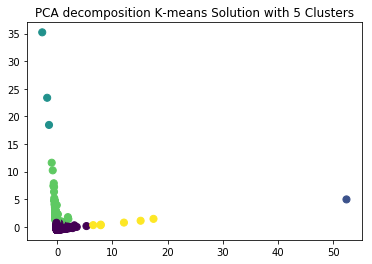

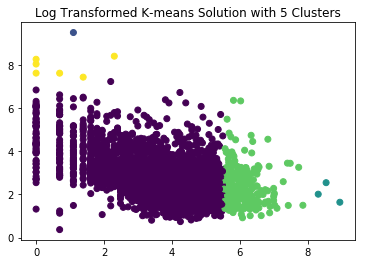

In [47]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=2, whiten=True)
pca.fit(CustomerID_groups[features_list])
CustomerID_groups['x'] = pca.fit_transform(CustomerID_groups[features_list])[:,0]
CustomerID_groups['y'] = pca.fit_transform(CustomerID_groups[features_list])[:,1]
plt.title('PCA decomposition K-means Solution with 5 Clusters')
plt.scatter(CustomerID_groups['x'],CustomerID_groups['y'], c=CustomerID_groups['cluster'], s=50 )
plt.show()

plt.title('Log Transformed K-means Solution with 5 Clusters')
plt.scatter(CustomerID_groups['count_log'],CustomerID_groups['value_log'], c=CustomerID_groups['cluster'] )
plt.show()




# Characteristics for each cluster base on Log Transformed K-means Solution with 5 Clusters.

## Note: in all graphs above X = count, Y = value

### I really like the number 5-cluster solution, it is abundantly clear for each cluster. 
### blue group (cluster 1) has a high-value, relatively-recent purchases and a low count (frequency), they are the the most valuable customer repesenting nearly 40% of total sales, is there any room to improve frenquency? (e.g. eliminating competition).
### green group (cluster2) has a low-value, high-count (frequency), and very recent purchase (5 days), it may be an indicator of promotional sales. 
### yellow group (cluster4) looks like they have similar characteristics as cluster 1, with low recent purchases.
### brown group (cluster3) has a medium-value, high frequency and most recent purchase (25 days), they are potentially representative of regular customers.
        CustomerID	     value	   count	 #Total_purchase           recency		 count_log         value_log
cluster											
    0	15547.952034	30.46	   55   	    1675.30                -102	         3.468813          2.898674
    
    1	15098.000000	13305.50   3            39915                  -65	         1.098612          9.495933
 
    2	14895.000000	8.45	   5608	        47387.60               -5	         8.596671          2.065466
    
    3	15651.663004	20.55	   456	        9370.80                -25	         6.008713          2.464378 
   
    4	16090.666667	2859.76	   3	        8579                   -130	         0.730338          7.893476
    

### As we move beyond 5 clusters, the graphs become increasingly hard to interpret visually, and the cluster centers start to make distinctions that may not be that helpful.



# END